### Overall Pipeline

In [1]:
img_i = 1

In [1]:
import cv2
from enum import Enum
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import json
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import torch

fx=2304.54786556982
fy=2305.875668062
cx=1686.23787612802
cy=1354.98486439791

camera_matrix = np.array([[fx, 0,  cx],
                          [0,  fy, cy],
                          [0,  0,  1 ]], dtype=np.float32)

dist_coeffs = np.zeros((1,4))

with open("../mesh/sedan_keypts.txt") as file:
    keypoints_list = []
    
    for line in file.readlines():
        line = line.strip('\n')
        x,y,z = line.split()
        keypoints_list.append([float(x),float(y),float(z)])
    sedan_keypoints_3D = np.array(keypoints_list,dtype="float")

with open("../mesh/sedan.json") as json_file:
    car_model = json.load(json_file)
    sedan_vertices = np.array(car_model['vertices'])  # x: w y: h z: l
    sedan_triangles = np.array(car_model['faces']) - 1

with open("../mesh/suv_keypts.txt") as file:
    keypoints_list = []
    
    for line in file.readlines():
        line = line.strip('\n')
        x,y,z = line.split()
        keypoints_list.append([float(x),float(y),float(z)])
    suv_keypoints_3D = np.array(keypoints_list,dtype="float")

with open("../mesh/suv.json") as json_file:
    car_model = json.load(json_file)
    suv_vertices = np.array(car_model['vertices'])  # x: w y: h z: l
    suv_triangles = np.array(car_model['faces']) - 1

def mask_to_polygons(mask):
    # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
    # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
    # Internal contours (holes) are placed in hierarchy-2.
    # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
    mask = np.ascontiguousarray(mask)  # some versions of cv2 does not support incontiguous arr
    res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    hierarchy = res[-1]
    if hierarchy is None:  # empty mask
        return [], False
    has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
    res = res[-2]
    res = [x.flatten() for x in res]
    # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
    # We add 0.5 to turn them into real-value coordinate space. A better solution
    # would be to first +0.5 and then dilate the returned polygon by 0.5.
    res = [x + 0.5 for x in res if len(x) >= 6][0].reshape(-1, 2)
    return res

def create_above_water_mask(detect_mask):
    mask_height, mask_wdith = detect_mask.shape

    above_water_mask = np.zeros_like(detect_mask)

    left_to_car = True
    right_to_car = False

    for v in range(0,mask_wdith):
        current_column = detect_mask[:,v]

        if left_to_car:
            if current_column.max() == 1.0:
                left_to_car = False
                vehicle_range = np.where(current_column==1)[0]
                min_u = vehicle_range.min()
                max_u = vehicle_range.max()
                edge_u = max_u
                above_water_mask[0:edge_u+1,0:v] = 1
                above_water_mask[0:min_u,v] = 1
        else:
            if right_to_car:
                above_water_mask[0:edge_u+1,v:mask_wdith] = 1
                break
            else:
                if current_column.max() == 1.0:
                    vehicle_range = np.where(current_column==1)[0]
                    min_u = vehicle_range.min()
                    max_u = vehicle_range.max()
                    edge_u = max_u
                    above_water_mask[0:min_u,v] = 1
                else:
                    right_to_car = True
                    above_water_mask[0:edge_u+1,v:mask_wdith] = 1
    return above_water_mask

def calculate_ground_truth_iou(detect_box,ground_truth_box):
    xmin1, ymin1, xmax1, ymax1 = detect_box
    xmin2, ymin2, xmax2, ymax2 = ground_truth_box
    x_overlap = max(0, min(xmax1, xmax2) - max(xmin1, xmin2))
    y_overlap = max(0, min(ymax1, ymax2) - max(ymin1, ymin2))
    intersection = x_overlap * y_overlap
    union = (xmax1 - xmin1) * (ymax1 - ymin1) + (xmax2 - xmin2) * (ymax2 - ymin2) - intersection
    return float(intersection) / union

def draw_obj(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.polylines(image, np.int32([coord]), 1, color)
        
def draw_obj_mask(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.fillPoly(image, np.int32([coord]),  color)

def draw_mask(image, vertices, triangles, block_vertices_list=[]):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.fillPoly(image, np.int32([coord]), 1)

def water_rising(vertices,index):
    top = np.max(vertices,0)[1]
    bottom = np.min(vertices,0)[1]

    water_level_ratio = index / 100  
    water_level = water_level_ratio * (top - bottom)

    level_bottom = bottom + water_level
    new_vertices = vertices.copy() # x: w y: h z: l

    for i_v, v in enumerate(new_vertices):
        if v[1] >= top - water_level:
            new_vertices[i_v][1] = top - water_level
            new_vertices[i_v][0] = 0
            new_vertices[i_v][2] = 0
        else:
            new_vertices[i_v] = v

    return new_vertices,water_level

class VehicleType(Enum):
    SEDAN = 1
    SUV = 2

class Vehicle:
    def __init__(self):
        self.segment = 0
        self.rcnn_mask = 0
        self.original_mask = 0
        self.original_box = 0

        self.expanded_box = np.array([],dtype="int")
        self.box_shape = (0,0)
        
        self.resized = False
        self.resized_shape = (0,0)
        
        self.keypoints = []
        self.keypoints_resized = []
        self.keypoints_id = []
        self.no_keypoints = False

        self.transfrom = (0,0)

        self.type = VehicleType.SEDAN

        self.water_level = 0.0

        self.ground_truth_waterlevel = 0.0
# image_folder = "D:\\Program\\Apollo\\instance\\train\\images\\"
# image_name = "171206_034625454_Camera_5.jpg"

image_folder = "../images/Flood/"
file_names = os.listdir(image_folder)
image_name = "Flood_1192.jpg"
# image_name = file_names[img_i]
# "Flood_183.jpg" flip
base_name = os.path.splitext(image_name)[0]
label_folder = "../images/labels/"
label_name = base_name+".json"

pil_image = Image.open(image_folder+image_name)
im_width, im_height = pil_image.size
np_image = np.array(pil_image)

with open(label_folder + label_name) as json_file:
    data = json.load(json_file)
    ground_truth = data['objects']


In [2]:
image_name

'Flood_1192.jpg'

c:\Users\JuJuBear\.conda\envs\Hiwi\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


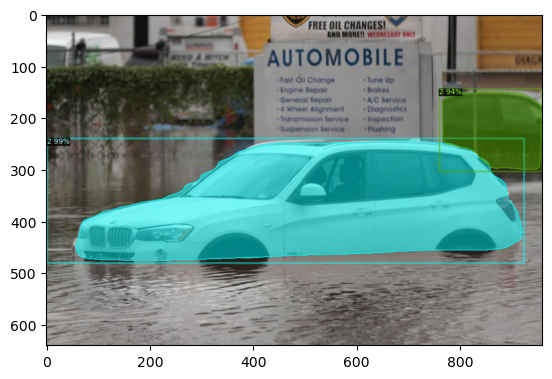

In [3]:
%matplotlib inline

cfg = get_cfg()
cfg.merge_from_file("../configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml") 

predictor = DefaultPredictor(cfg)
predictions = predictor(np_image)

visualizer = Visualizer(np_image)

instances = predictions["instances"].to(torch.device("cpu"))
instances = instances[instances.pred_classes==2]
instances = instances[instances.scores > 0.80]

vis_output = visualizer.draw_instance_predictions(predictions=instances)

plt.figure()
plt.imshow(vis_output.get_image())
plt.show()

In [24]:
max_square_size = 256 # 256 128

apply_mask = True

valid cars amount:1


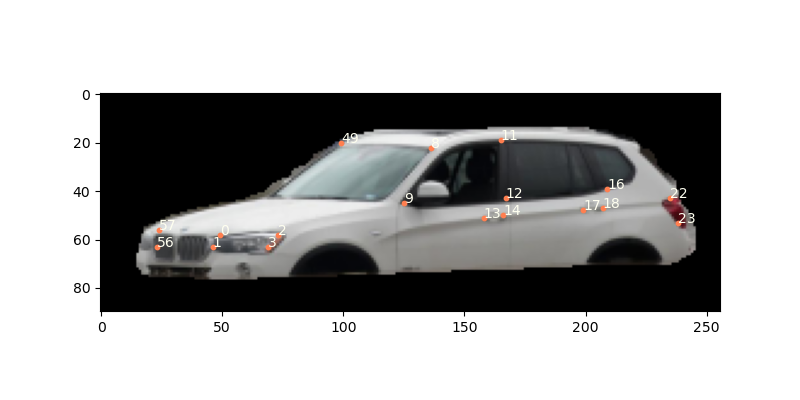

In [25]:

import openpifpaf

cars = []


car_amount = len(instances)
for i in range(car_amount):
    # data acquiation
    box = instances.pred_boxes[i].tensor.numpy()[0]
    mask = np.zeros((im_height,im_width))
    mask[instances.pred_masks[i].numpy()] = 1

    # get size
    x1 = box[0]
    y1 = box[1]
    x2 = box[2]
    y2 = box[3]
    box_width = x2 - x1
    box_height = y2 - y1
    
    
    # expand the box and cut
    width_increment = 0.2*box_width
    height_increment = 0.2*box_height
    new_x1 = int(max(x1 - width_increment,0))
    new_y1 = int(max(y1 - height_increment,0))
    new_x2 = int(min(x2 + width_increment,im_width))
    new_y2 = int(min(y2 + height_increment,im_height))
    new_box_width = new_x2 - new_x1
    new_box_height = new_y2 - new_y1

    new_box = np.array([new_x1,new_y1,new_x2,new_y2],dtype="int")

    new_segment = np_image[new_y1:new_y2,new_x1:new_x2]

    # do the mask
    mask_seg = mask[new_y1:new_y2,new_x1:new_x2]

    # resize
    vehicle = Vehicle()
    vehicle.rcnn_mask = instances.pred_masks[i].numpy()
    vehicle.original_box = box
    vehicle.original_mask = mask
    vehicle.expanded_box = new_box
    vehicle.box_shape = (new_box_width,new_box_height)
    
    max_length = max(new_box_width,new_box_height)
    if max_length > max_square_size:
        ratio = max_square_size / max_length
        resized_width = int(new_box_width * ratio)
        resized_height = int(new_box_height * ratio)
        resized_segment = cv2.resize(new_segment,(resized_width,resized_height),interpolation = cv2.INTER_AREA)
        resized_maskseg = cv2.resize(mask_seg,(resized_width,resized_height),interpolation = cv2.INTER_AREA)
        vehicle.resized = True
        vehicle.resized_shape = (resized_width,resized_height)
    else:
        resized_segment = new_segment
        resized_maskseg = mask_seg

    mask_3 = np.expand_dims(resized_maskseg, axis=2)
    mask_3 = np.concatenate((mask_3, mask_3, mask_3), axis=-1)
    if apply_mask:
        resized_segment = np.where(mask_3, resized_segment, 0)

    vehicle.segment = resized_segment
    cars.append(vehicle)

kpt_outliers = [58,59,60,61,62,63,64,65]
# kpt_outliers = []
kpt_inliers = []

CppCifCaf = torch.classes.openpifpaf_decoder.CifCaf
# CppCifCaf.set_force_complete(True)
CppCifCaf.set_keypoint_threshold(0.0)
Keypoints = torch.classes.openpifpaf_decoder_utils.NMSKeypoints
Keypoints.set_instance_threshold(0.00)
Keypoints.set_keypoint_threshold(0.00)

predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-apollo-66')
kpt_amount = 66

for car in cars:
    predictions, gt_anns, image_meta = predictor.numpy_image(car.segment)
    if len(predictions)<4:
        car.no_keypoints = True    
        continue
    keypoints = predictions[0].data.tolist()
        
    visable_index = []
    visable_keypoints_2D = []
    recovered_keypoints_2D = []
    for i in range(0,kpt_amount):
        if i in kpt_outliers:
            continue

        x = keypoints[i][0]
        y = keypoints[i][1]
        score = keypoints[i][2]
        if(score > 0.0):
            visable_index.append(i)
            visable_keypoints_2D.append([x,y])

            if car.resized:
                resized_width, resized_height = car.resized_shape
                box_width, box_height = car.box_shape
                x_ratio = x / resized_width
                y_ratio = y / resized_height
                recovered_x = box_width * x_ratio + car.expanded_box[0]
                recovered_y = box_height * y_ratio + car.expanded_box[1]
            else:
                recovered_x = x + car.expanded_box[0]
                recovered_y = y + car.expanded_box[1]
            
            recovered_keypoints_2D.append([recovered_x,recovered_y])

    if len(recovered_keypoints_2D)<4:
        car.no_keypoints = True
    else:
        car.keypoints_resized = visable_keypoints_2D
        car.keypoints = recovered_keypoints_2D
        car.keypoints_id = visable_index

valid_cars = [car for car in cars if not car.no_keypoints]


car_amount = len(valid_cars)
print(f"valid cars amount:{car_amount}")
plt.figure(figsize=(8,car_amount*4))

for i,car in enumerate(valid_cars):
    plt.subplot(car_amount,1,i+1)
    
    for kpt,kpt_id in zip(car.keypoints_resized,car.keypoints_id):
        plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
        plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)
    plt.imshow(car.segment)
plt.show()   


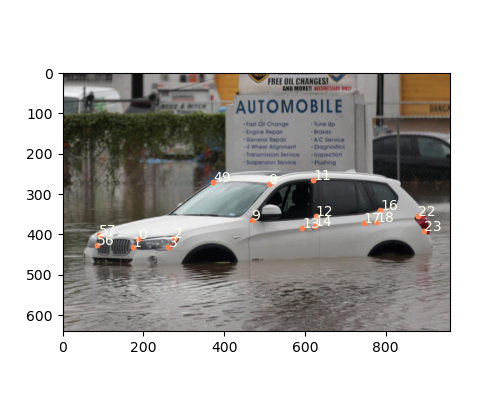

In [26]:
car_amount = len(valid_cars)
plt.figure(figsize=(5,car_amount*4))
for i,car in enumerate(valid_cars):
    plt.subplot(car_amount,1,i+1)
    
    for kpt,kpt_id in zip(car.keypoints,car.keypoints_id):
        plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
        plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "ivory",fontsize=10)
    plt.imshow(np_image)
plt.show()  

In [27]:
# determine groundtruth
for car in valid_cars:
    max_iou = 0
    found = False
    for gt in ground_truth:
        iou = calculate_ground_truth_iou(car.original_box,gt['bbox'])
        if iou > max_iou:
            max_iou = iou
            the_gt = gt
            found = True
    if found: 
        print(max_iou)
        car.ground_truth_waterlevel = int(the_gt['water_level']) / 100
        print(car.ground_truth_waterlevel)
        if int(the_gt['cls']) == 0:
            car.type == VehicleType.SEDAN
            print("sedan")
        else:
            car.type == VehicleType.SUV
            print("suv")

0.8938285125388661
0.6
suv


In [28]:
for car in valid_cars:
    print(car.type)

VehicleType.SEDAN


# Show

In [40]:
need_flip = False
need_detect_keypoint = True
need_project_keypoint = True
need_project_keypoint_all = False
need_detect_mask = True
need_waterlevel_mask = False
need_box = False
need_project_obj_mask = False
need_project_obj = True

flag = cv2.SOLVEPNP_EPNP
# flag = cv2.SOLVEPNP_ITERATIVE

Vehicle 1
suv
reprojectionError:2.863511353984587
reprojectionError various:73.79328356272786
iou_overlap:0.6580802002599528
iou_fill:0.9167130489595837
iou_outside:0.0015769801853463723
water level:0.5837783456000001


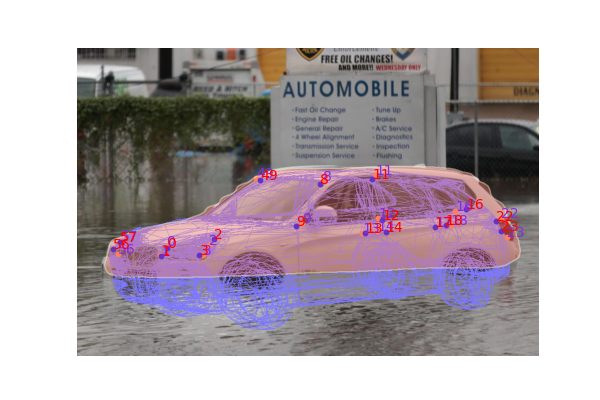

In [41]:
%matplotlib widget

car_amount = len(valid_cars)

plt.figure(figsize=(6,car_amount*4))


for i,car in enumerate(valid_cars):
    print(f"Vehicle {i+1}")
    ax = plt.subplot(car_amount,1,i+1)
    plt.axis('off')

    # if car.type.name == "SEDAN":
    #     print("sedan")
    #     keypoints_3D = sedan_keypoints_3D.copy()
    #     vertices = sedan_vertices.copy()
    #     faces = sedan_triangles.copy()
    # else:
    print("suv")
    keypoints_3D = suv_keypoints_3D.copy()
    vertices = suv_vertices.copy()
    faces = suv_triangles.copy()

    if need_flip:
        keypoints_3D[:,0] = keypoints_3D[:,0] * -1
        vertices[:,0] = vertices[:,0] * -1

    imgPoints = np.array(car.keypoints,dtype='float64')
    objPoints = keypoints_3D[car.keypoints_id]
    
    
    (return_value, rotation_vector, translation_vector) = cv2.solvePnP(objPoints,
                                                                        imgPoints,
                                                                        camera_matrix,
                                                                        dist_coeffs,
                                                                        flags=flag)
    new_vertices = vertices
    keypoints_3D_visable = objPoints

    (projected_vertices, jacobian_model) = cv2.projectPoints(new_vertices, 
                                                                rotation_vector, 
                                                                translation_vector,
                                                                camera_matrix, 
                                                                dist_coeffs)

    (projected_keypoints, jacobian_model) = cv2.projectPoints(keypoints_3D_visable, 
                                                                rotation_vector, 
                                                                translation_vector,
                                                                camera_matrix, 
                                                                dist_coeffs)
    projected_keypoints = np.squeeze(projected_keypoints,axis=1)

    (projected_keypoints_all, jacobian_model) = cv2.projectPoints(keypoints_3D, 
                                                                rotation_vector, 
                                                                translation_vector,
                                                                camera_matrix, 
                                                                dist_coeffs)

    reprojectionError = cv2.norm(imgPoints,projected_keypoints,cv2.NORM_L2) / len(imgPoints)
    r_var = np.var(imgPoints - projected_keypoints)
    

    copy_image = np_image.copy()

    projected_mask = np.zeros_like(car.original_mask)
    draw_mask(projected_mask,projected_vertices,faces)

    overlap_mask = projected_mask + car.original_mask
    area_detected = car.original_mask.sum()
    area_projected = projected_mask.sum()
    area_overlaped = (overlap_mask==2).sum()
    area_detected_filled = car.original_mask[overlap_mask==2].sum()
    above_water_mask = create_above_water_mask(car.original_mask)
    outliers_mask = projected_mask + above_water_mask
    area_outside = (outliers_mask==2).sum()
    area_union = area_detected + area_projected - area_overlaped

    iou_overlap = area_overlaped / area_union
    iou_fill = area_detected_filled / area_detected
    iou_outside = area_outside / area_projected

    print(f"reprojectionError:{reprojectionError}")
    print(f"reprojectionError various:{r_var}")
    print(f"iou_overlap:{iou_overlap}")
    print(f"iou_fill:{iou_fill}")
    print(f"iou_outside:{iou_outside}")

    if need_detect_keypoint:
        for kpt,kpt_id in zip(car.keypoints,car.keypoints_id):
            
            plt.scatter(int(kpt[0]),int(kpt[1]),c='coral', s=10)
            plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "blueviolet",fontsize=10)

    if need_project_keypoint:
        for keypoint,kpt_id in zip(projected_keypoints,car.keypoints_id):
            kpt = keypoint

            plt.scatter(int(kpt[0]),int(kpt[1]),c='blue', s=10)
            plt.text(int(kpt[0]), int(kpt[1]), str(kpt_id),color = "red",fontsize=10)

    if need_project_keypoint_all:
        for i,keypoint in enumerate(projected_keypoints_all):
            kpt = keypoint[0]

            plt.scatter(int(kpt[0]),int(kpt[1]),c='blue', s=10)
            plt.text(int(kpt[0]), int(kpt[1]), str(i),color = "red",fontsize=10)

    

    if need_project_obj_mask:
        polygon_seg2 = patches.Polygon(
            mask_to_polygons(projected_mask),
            fill=True,
            facecolor="lightgreen",
            edgecolor="lightyellow",
            linewidth=1,
            alpha=0.6
        )
        ax.add_patch(polygon_seg2)

    if need_project_obj:
        draw_obj(copy_image,projected_vertices,faces,(125,120,255))

    if need_detect_mask:
        polygon_seg = patches.Polygon(
            mask_to_polygons(car.rcnn_mask),
            fill=True,
            facecolor="salmon",
            edgecolor="lightyellow",
            linewidth=1,
            alpha=0.4
        )
        ax.add_patch(polygon_seg)
    
    max_iou_waterlevel = 0
    right_waterlevel = 0
    right_waterlevel_mask = 0
    all_ious = []
    for i in range(0,100):
        filtered_vertices,water_level = water_rising(vertices,i)
        (projected_waterlevel_vertices, _) = cv2.projectPoints(filtered_vertices, 
                                                rotation_vector, 
                                                translation_vector,
                                                camera_matrix, 
                                                dist_coeffs)
        waterlevel_mask = np.zeros_like(car.original_mask)
        draw_mask(waterlevel_mask,projected_waterlevel_vertices,faces)

        overlap_waterlevel_mask = waterlevel_mask + car.original_mask
        area_waterlevel = waterlevel_mask.sum()
        area_overlap_waterlevel = (overlap_waterlevel_mask==2).sum()
        area_union_waterlevel = area_detected + area_waterlevel - area_overlap_waterlevel

        iou_waterlevel = area_overlap_waterlevel / area_union_waterlevel
        all_ious.append(iou_waterlevel)
        if iou_waterlevel > max_iou_waterlevel:
            max_iou_waterlevel = iou_waterlevel
            right_waterlevel = water_level
            right_waterlevel_mask = waterlevel_mask

    print(f"water level:{right_waterlevel}")
    car.water_level = right_waterlevel
    if need_waterlevel_mask:
        copy_image[right_waterlevel_mask.astype(bool)] = [90,50,255]

    if need_box:
        x1 = car.original_box[0]
        y1 = car.original_box[1]
        x2 = car.original_box[2]
        y2 = car.original_box[3]
        plt.text(int(x1), int(y1-23), f"GT: {round(car.ground_truth_waterlevel,2)}",color = "cyan",fontsize=10)
        plt.text(int(x1), int(y1-7), f"Pred: {round(car.water_level,2)}",color = "cyan",fontsize=10)
        rect = patches.Rectangle((int(x1), int(y1)), int(x2-x1), int(y2-y1), fill=False, edgecolor = 'cyan',linewidth=1)
        ax.add_patch(rect)

    plt.imshow(copy_image)

plt.show()


In [42]:
plt.savefig("../result_img_2/"+image_name,bbox_inches='tight',dpi=200,pad_inches=0.0)

In [12]:
with open("../result/"+base_name+".txt","w") as file:
    file.write(f"detected waterlevel:{car.water_level}\r\n")
    file.write(f"ground truth waterlevel:{car.ground_truth_waterlevel}\r\n")
    file.write(f"water level error:{car.water_level - car.ground_truth_waterlevel}\r\n")
plt.savefig("../result_img_2/"+image_name,bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

NameError: name 'fig' is not defined